In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.gridspec as grid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

data = pd.read_csv("Data\CarPrice_Assignment.csv")

data[['symboling']]=data[['symboling']].astype('category')

data['brandName']=data['CarName'].apply(lambda x:x.split(' ')[0].lower().strip())

data.loc[(data['brandName']=='vw' )| (data['brandName']=='vokswagen'),'brandName']='volkswagen'


data.loc[(data['brandName']=='porcshce')|(data['brandName']=='porsche'),'brandName']='porsche'

data.loc[(data['brandName']=='toyouta' ),'brandName']='toyota'

data_num=data.select_dtypes(include=[np.number])

data_num=data_num.iloc[:,1:]

data_cat=data.select_dtypes(exclude=[np.number])

In [2]:
data_cat.columns

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem', 'brandName'],
      dtype='object')

# Findings from scatter plot:

<br>1) Wheelbase is highly corelated with car length. It is understandable as wheelbase is length between the axels. if needed we will use a new metric extra length = car length - wheelbase
<br>2) Wheelbase, car length, car width, curb weight are highly corelated. can we come up with better metrics?
<br>3) Car length (and other associated variables) and  engine size are non-linearly corelated
<br>4) Car length and horsepower are non-linearly corelated
<br>5) curb weight and horsepower strong correlation
<br>6) car length (and other associated variables) strongly correlated with citympg and highwaympg
<br>7) horsepower, citympg, highwaympg highly corelated (somewhat nonlinearly)
<br>8) Mild correlation
   <br>a) Engine Size - Bore Ration
    <br>b) bore ratio - mpg variables
    <br>c) car width horsepower
   <br>d) car length (and other associated variables) with other 
<br>9) stoke, car height, peak rpm have correlation with price (dependent) and other independent variables
<br>10) as expected, both mpg variable are strongly corelated. we should take harmonic mean to get to an average value.
<br>11) wheelbase has +ve correlation with price, but mild. may need some transformation as variable is right skewed
<br>12) car length has moderately strong nonlinear relation with price. same for car width
<br>13) mpgs have high nonlinear relation with y
<br>14) bore ratio has mild correlation with y but during univariate analysis we say two peaks. may by including categorical <br>variable it improves
<br>15) horse power has strong correlation with y. but with funnel may need transformation
<br>16) engine size strongly corelated with price


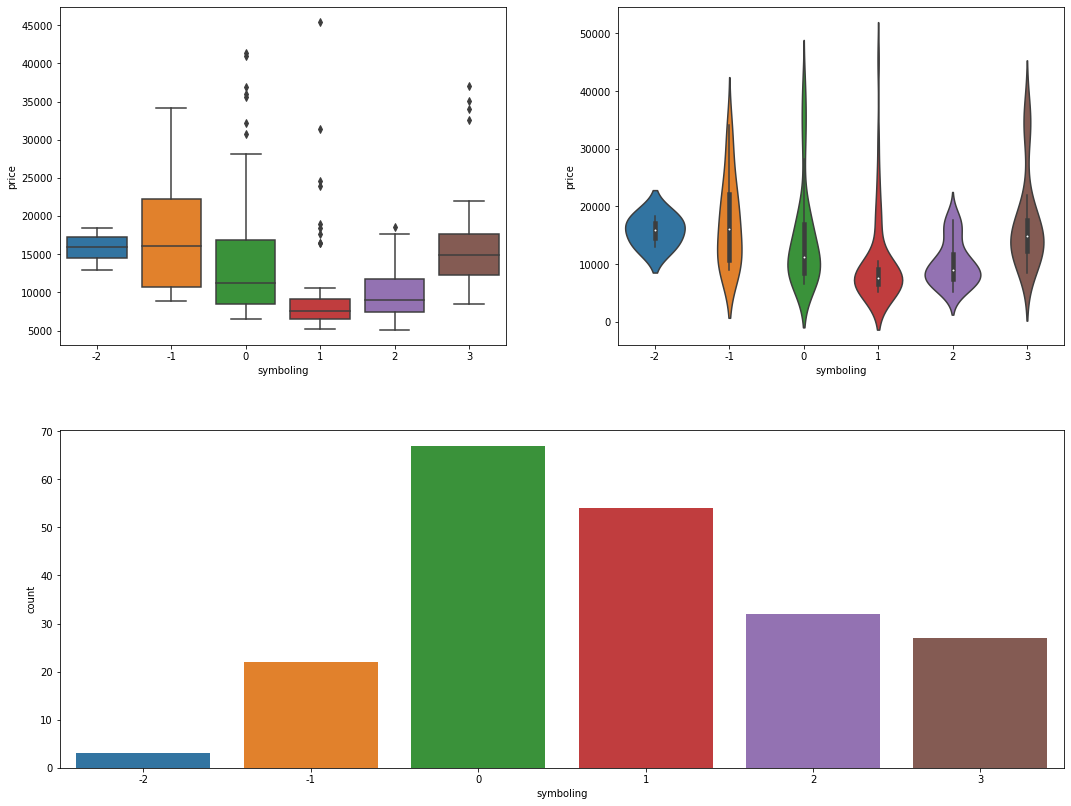

In [3]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='symboling', y='price',ax=ax0)
sns.violinplot(data = data, x='symboling', y='price',ax=ax1)
sns.countplot(data=data,x='symboling',ax=ax2)
plt.show()

In [4]:
data['symboling'].value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

In [5]:
def symboling_group(x):
    
    if(int(x) in [-2,-1]):
        return 'level-1_-2'
    elif(int(x) in [1,2]):
        return '1_2_level_pos'
    else:
        return str(x)
data['symboling']=data['symboling'].apply(lambda x:symboling_group(x))

In [6]:
data['symboling'].value_counts()

1_2_level_pos    86
0                67
3                27
level-1_-2       25
Name: symboling, dtype: int64

### I am grouping Symboling as -2 has only 3 examples. and it was creating outliers and 'NA' for regression coefficient in a test fit

### Symboling corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.-1,-2 and 1,2 are quite same. rest groups are different

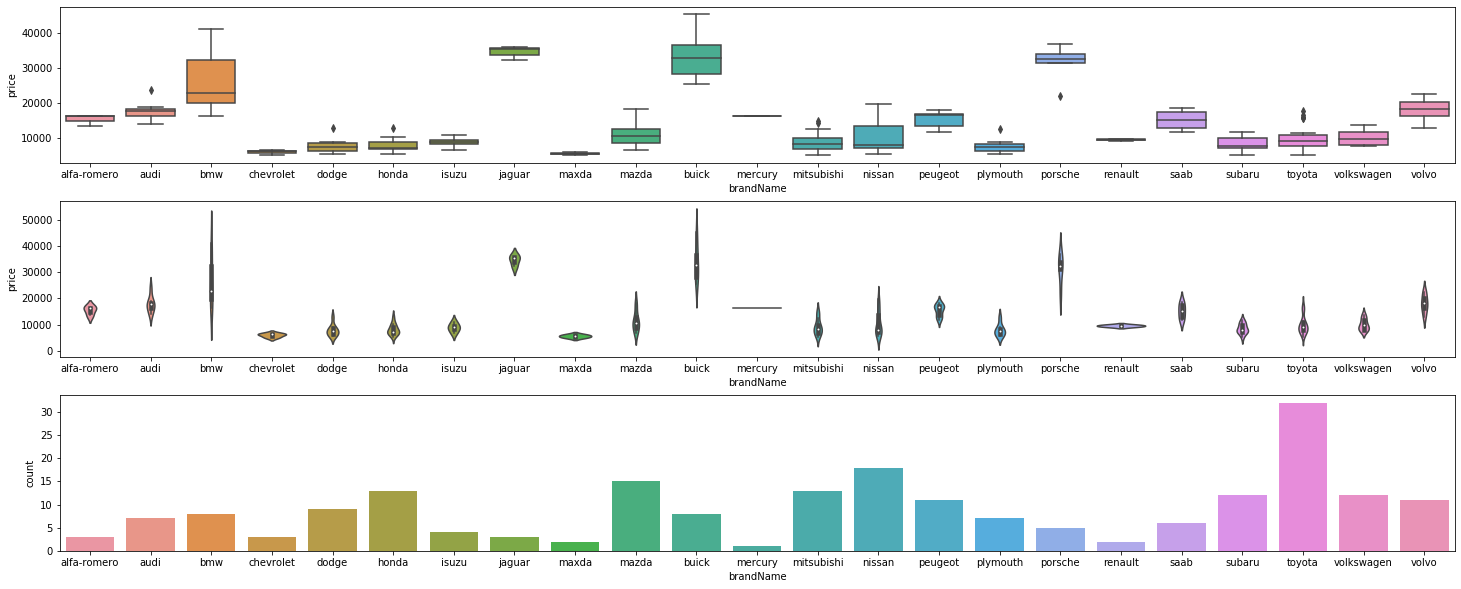

In [7]:
fig = plt.figure(figsize=(25, 10))
gs = grid.GridSpec(3, 1, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])
sns.boxplot(data = data, x='brandName', y='price',ax=ax0)
sns.violinplot(data = data, x='brandName', y='price',ax=ax1)
sns.countplot(data=data,x='brandName',ax=ax2)
plt.show()

#### Brand Name Grouping Also required as two many categories and in some categories very few example.

In [8]:
def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.mean().sort_values()
  df2[meds.index].boxplot(rot=90)

In [9]:
data['lnprice']=np.log(data['price'])

In [10]:
data['brandName']=data['brandName'].apply(lambda x:'mazda' if x=='maxda' else x)

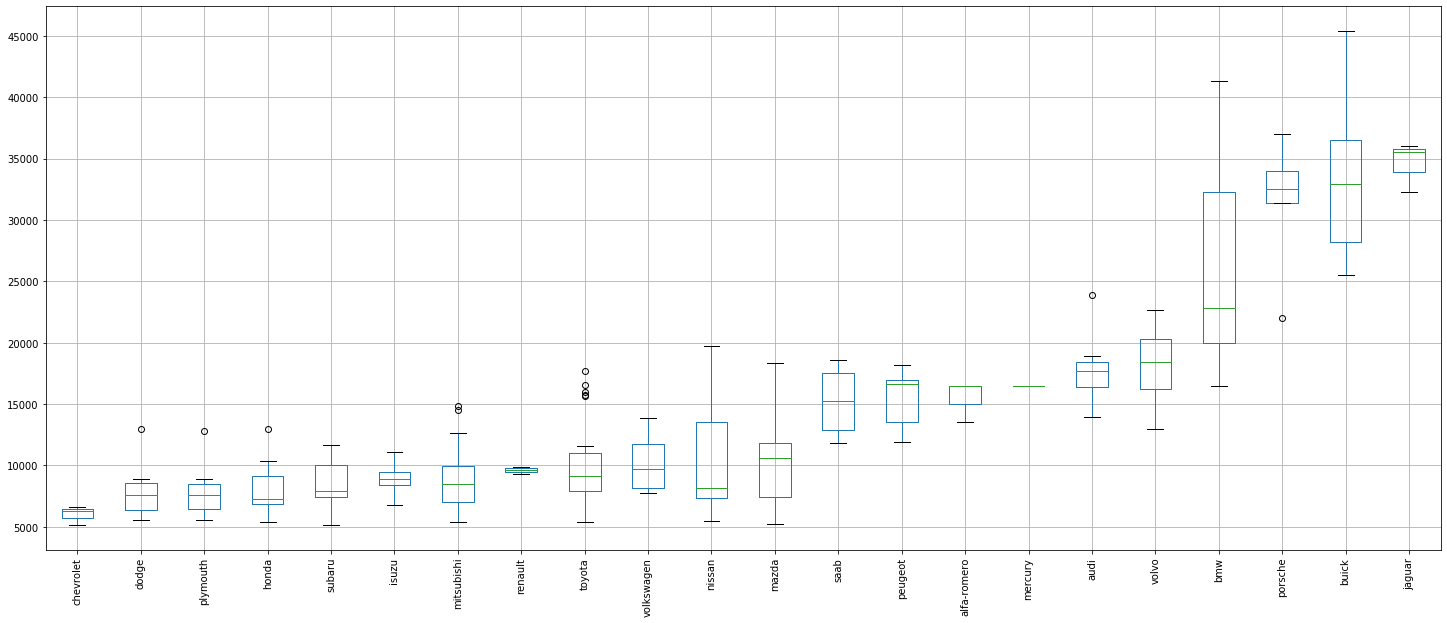

In [96]:
fig = plt.figure(figsize=(25, 10))
boxplot_sorted(data, by=["brandName"], column="price")

In [98]:
data['brandName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [99]:
def brand_group(x):
    entry_level=['chevrolet','dodge','plymouth','honda','subaru','isuzu','mitsubishi','renault','toyota','nissan','mazda','volkswagen']
    mid_level=['saab','peugeot','alfa-romero','mercury','audi','volvo','bmw']
    high_end=['porsche','buick','jaguar']
    
    if(x in entry_level):
        return 'entry_level'
    elif(x in mid_level):
        return 'mid_level'
    elif(x in high_end):
        return 'high_end'
    else:
        return 'other'


In [100]:
data['brandName']=data['brandName'].apply(lambda x:brand_group(x))

In [101]:
data['brandName'].value_counts()

entry_level    142
mid_level       47
high_end        16
Name: brandName, dtype: int64

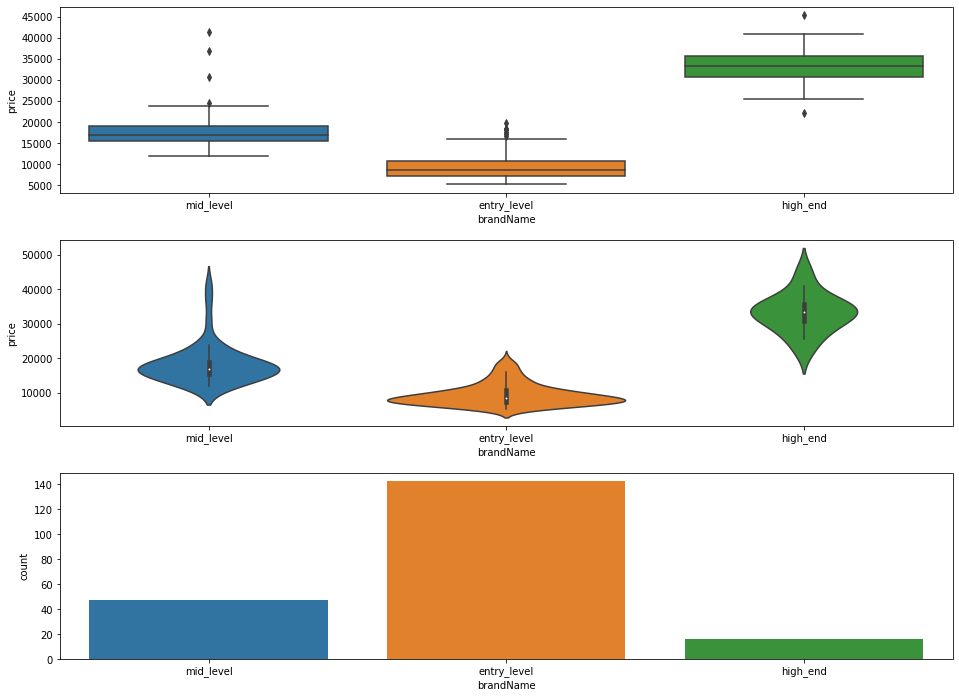

In [102]:
fig = plt.figure(figsize=(16, 12))
gs = grid.GridSpec(3, 1, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])
sns.boxplot(data = data, x='brandName', y='price',ax=ax0)
sns.violinplot(data = data, x='brandName', y='price',ax=ax1)
sns.countplot(data=data,x='brandName',ax=ax2)
plt.show()

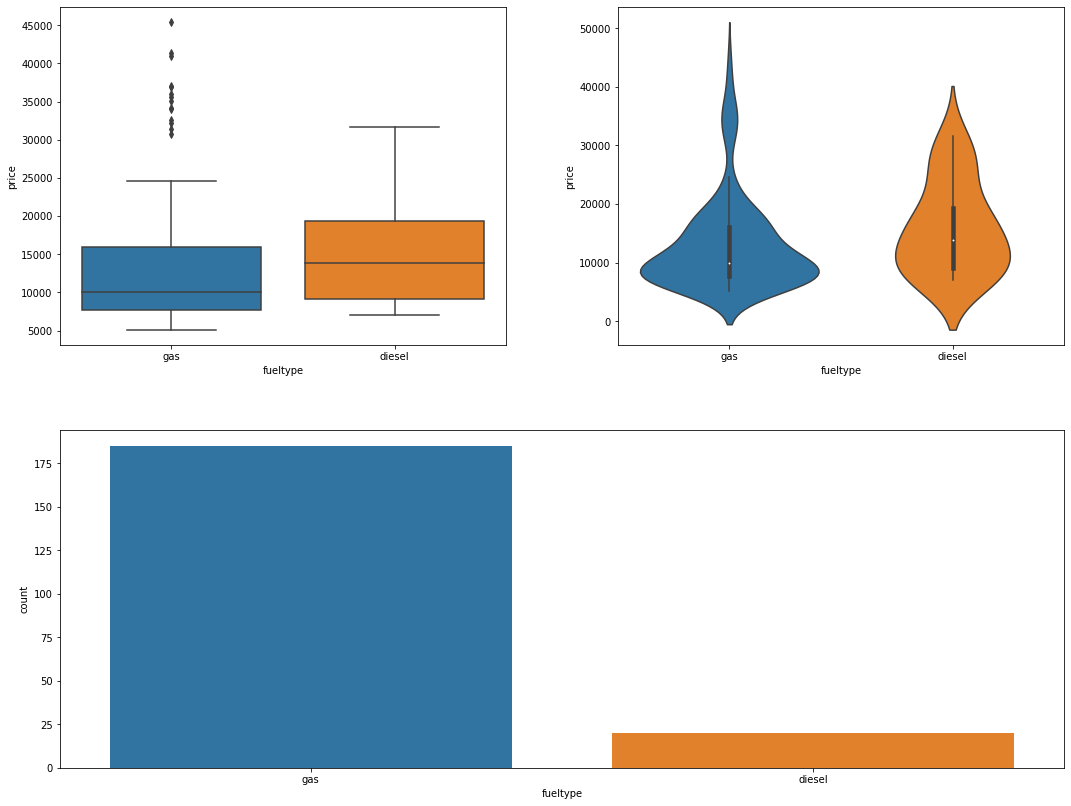

In [103]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='fueltype', y='price',ax=ax0)
sns.violinplot(data = data, x='fueltype', y='price',ax=ax1)
sns.countplot(data=data,x='fueltype',ax=ax2)
plt.show()

Gas and Diesel price level differs but not much. Diesels category dont have much cars.

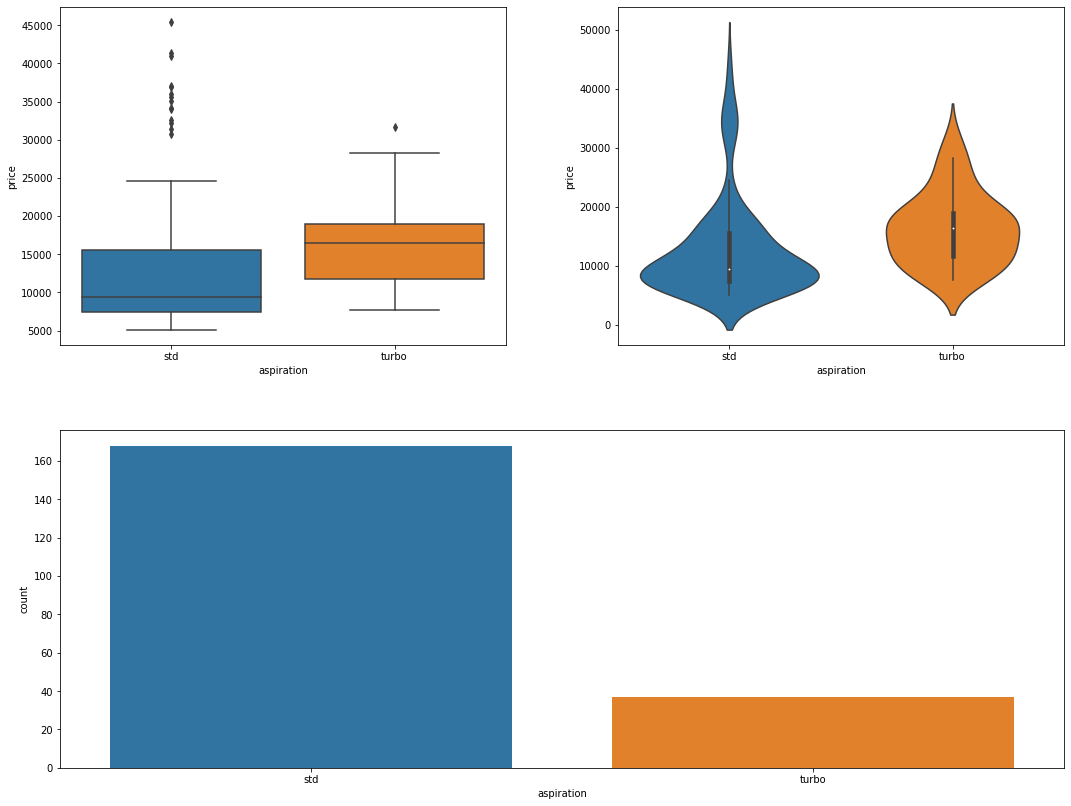

In [104]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='aspiration', y='price',ax=ax0)
sns.violinplot(data = data, x='aspiration', y='price',ax=ax1)
sns.countplot(data=data,x='aspiration',ax=ax2)
plt.show()

Diffenrece in  price for each category is there

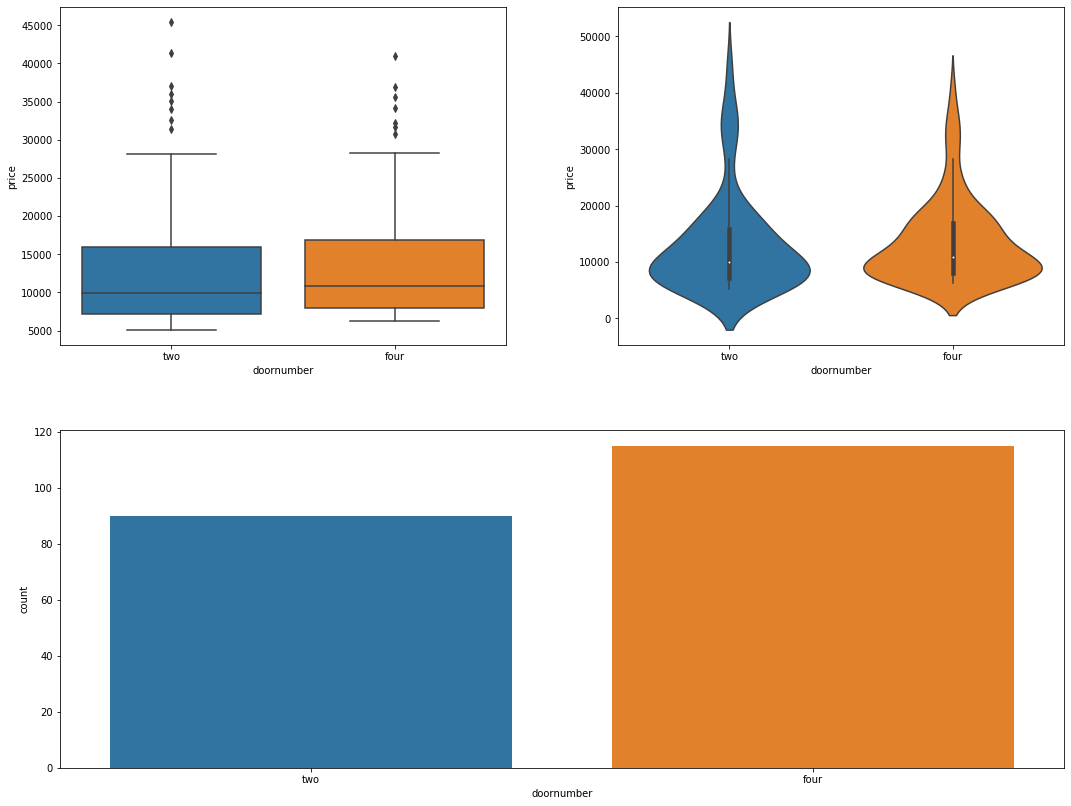

In [105]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='doornumber', y='price',ax=ax0)
sns.violinplot(data = data, x='doornumber', y='price',ax=ax1)
sns.countplot(data=data,x='doornumber',ax=ax2)
plt.show()


Doornumber: not much difference in price.

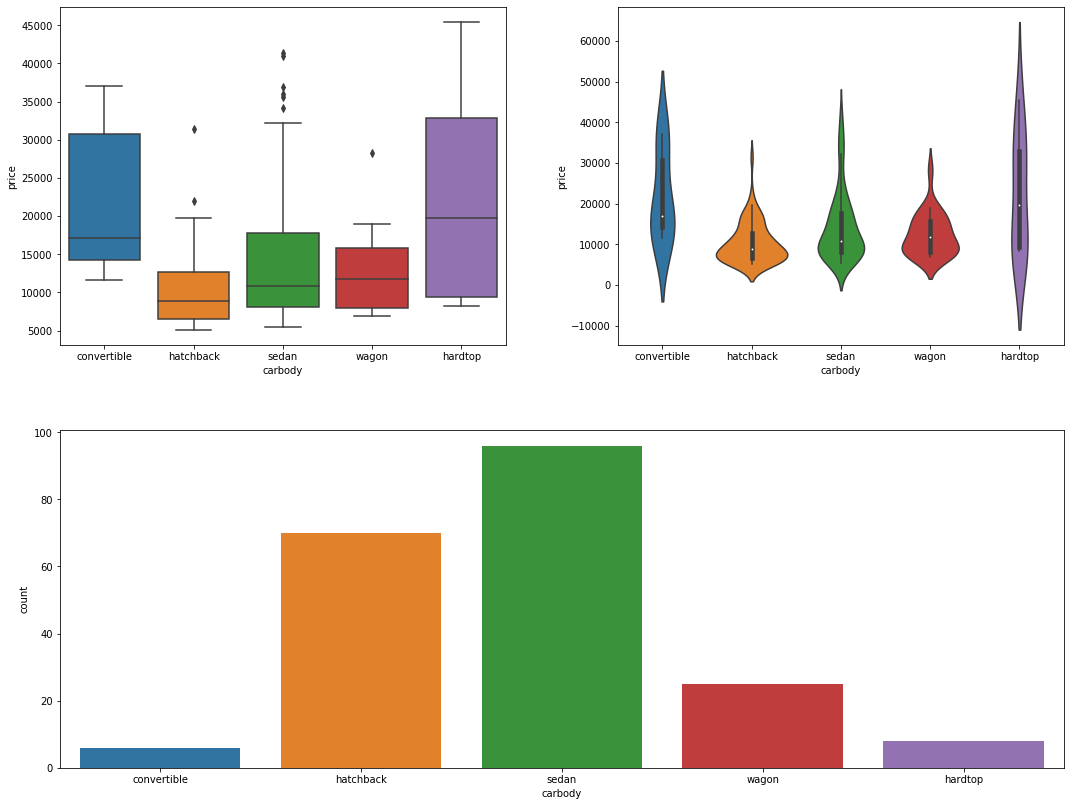

In [106]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='carbody', y='price',ax=ax0)
sns.violinplot(data = data, x='carbody', y='price',ax=ax1)
sns.countplot(data=data,x='carbody',ax=ax2)
plt.show()


In [107]:
data['carbody'].value_counts()

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64

Convertiable and hardtop price quite different from the rest

In [108]:
def carbody_group(x):
    level_convertible_hardtop=['convertible','hardtop']
    level_wagon_hatchback=['wagon','hatchback']
    
    if(x in level_convertible_hardtop):
        return 'level_convertible_hardtop'
    if(x in level_wagon_hatchback):
        return 'level_wagon_hatchback'
    else:
        return x


In [109]:
data['carbody']=data['carbody'].apply(lambda x:carbody_group(x))
data['carbody'].value_counts()

sedan                        96
level_wagon_hatchback        95
level_convertible_hardtop    14
Name: carbody, dtype: int64

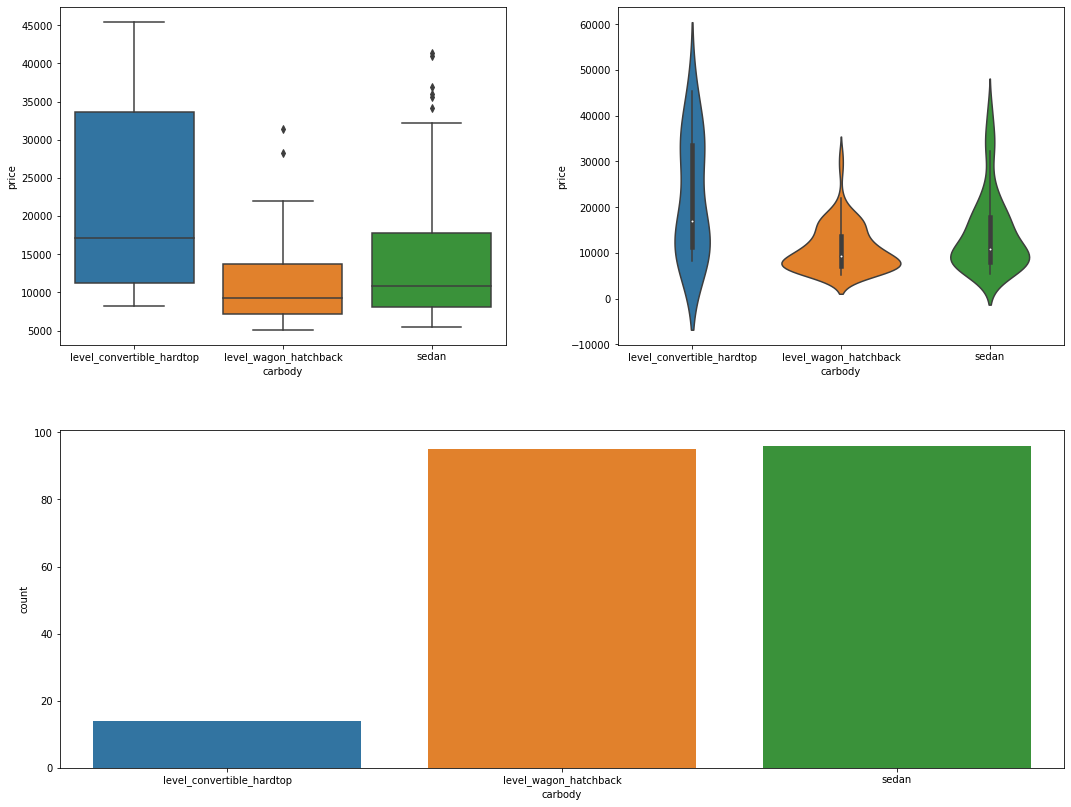

In [110]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='carbody', y='price',ax=ax0)
sns.violinplot(data = data, x='carbody', y='price',ax=ax1)
sns.countplot(data=data,x='carbody',ax=ax2)
plt.show()

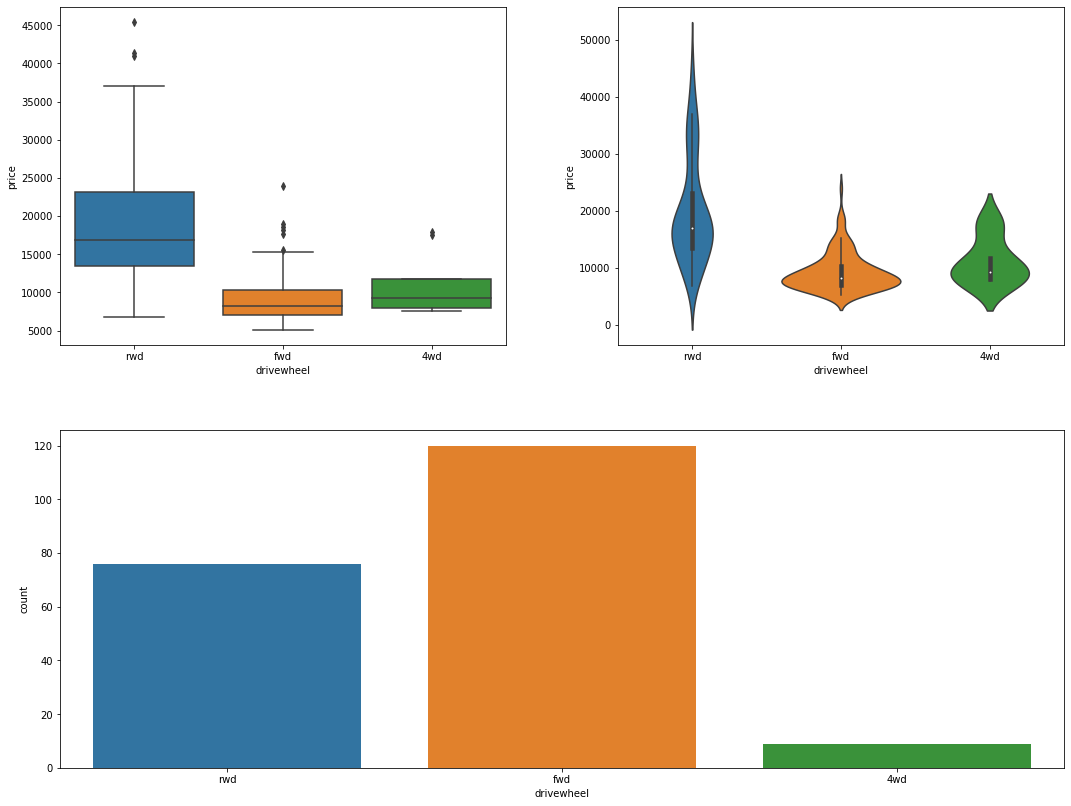

In [111]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='drivewheel', y='price',ax=ax0)
sns.violinplot(data = data, x='drivewheel', y='price',ax=ax1)
sns.countplot(data=data,x='drivewheel',ax=ax2)
plt.show()

rwd is very different from fwd and 4wd

#### I am grouping drivewheel becuase 1) FWD AND 4WD is quite similar 2) during an intial model fit I found the corefficent for them fwd was insiginificant when 4wd as base but rwd is significnat

In [112]:
def drivewheel_group(x):
        
    if(x in ['fwd','4wd']):
        return '4wd_fed'
    else:
        return x

In [113]:
data['drivewheel']=data['drivewheel'].apply(lambda x:drivewheel_group(x))
data['drivewheel'].value_counts()

4wd_fed    129
rwd         76
Name: drivewheel, dtype: int64

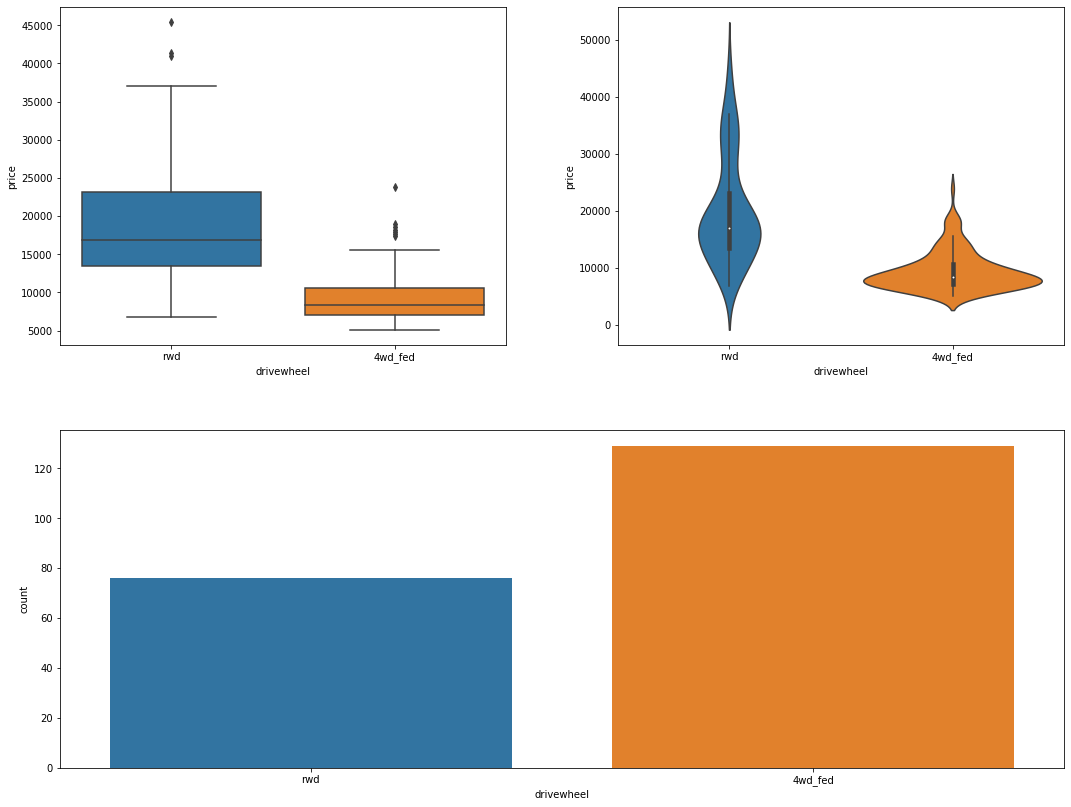

In [114]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='drivewheel', y='price',ax=ax0)
sns.violinplot(data = data, x='drivewheel', y='price',ax=ax1)
sns.countplot(data=data,x='drivewheel',ax=ax2)
plt.show()

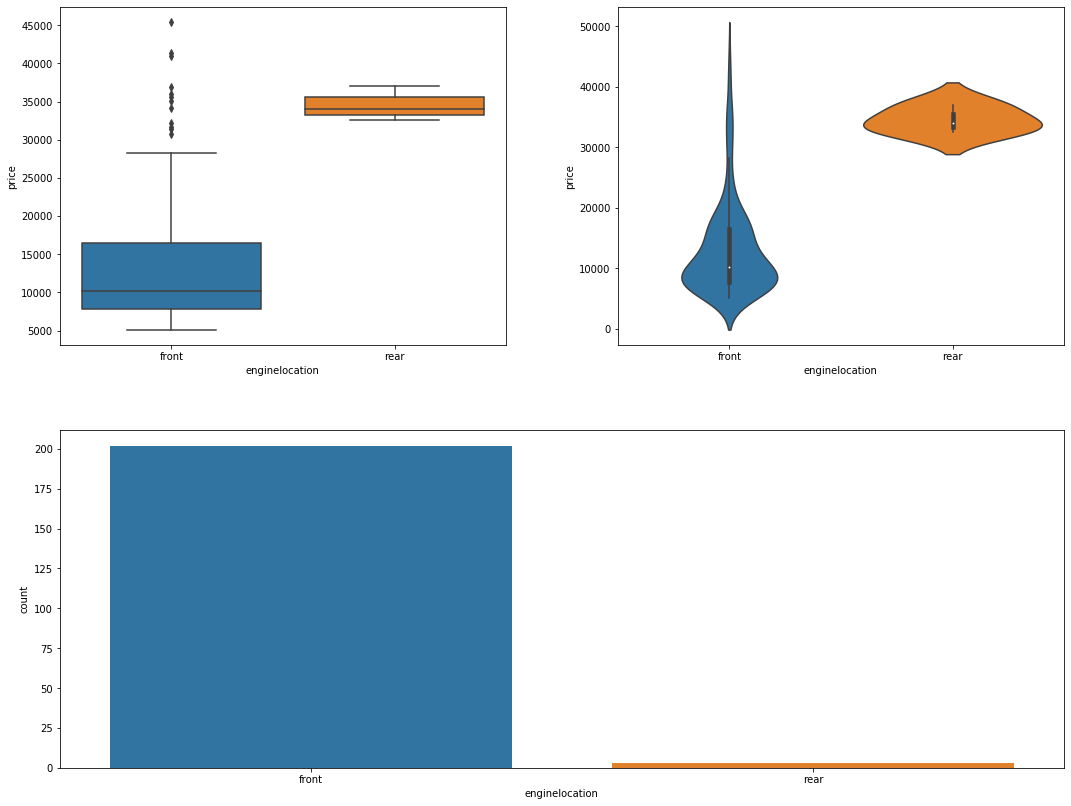

In [115]:


fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='enginelocation', y='price',ax=ax0)
sns.violinplot(data = data, x='enginelocation', y='price',ax=ax1)
sns.countplot(data=data,x='enginelocation',ax=ax2)
plt.show()

only 3 cars in rear that of porche. variable might not be that usable

In [116]:
datax=data[['drivewheel','enginelocation']]

datax['num1']=1

datax.pivot_table(values='num1',index='drivewheel', columns='enginelocation', aggfunc='sum')

C:\Users\prateekk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


enginelocation,front,rear
drivewheel,,
4wd_fed,129.0,NaN
rwd,73.0,3.0


In [117]:

datax=data[['brandName','enginelocation']]
datax['num1']=1

datax.pivot_table(values='num1',index='brandName', columns='enginelocation', aggfunc='sum').dropna()

C:\Users\prateekk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


enginelocation,front,rear
brandName,,
high_end,13.0,3.0


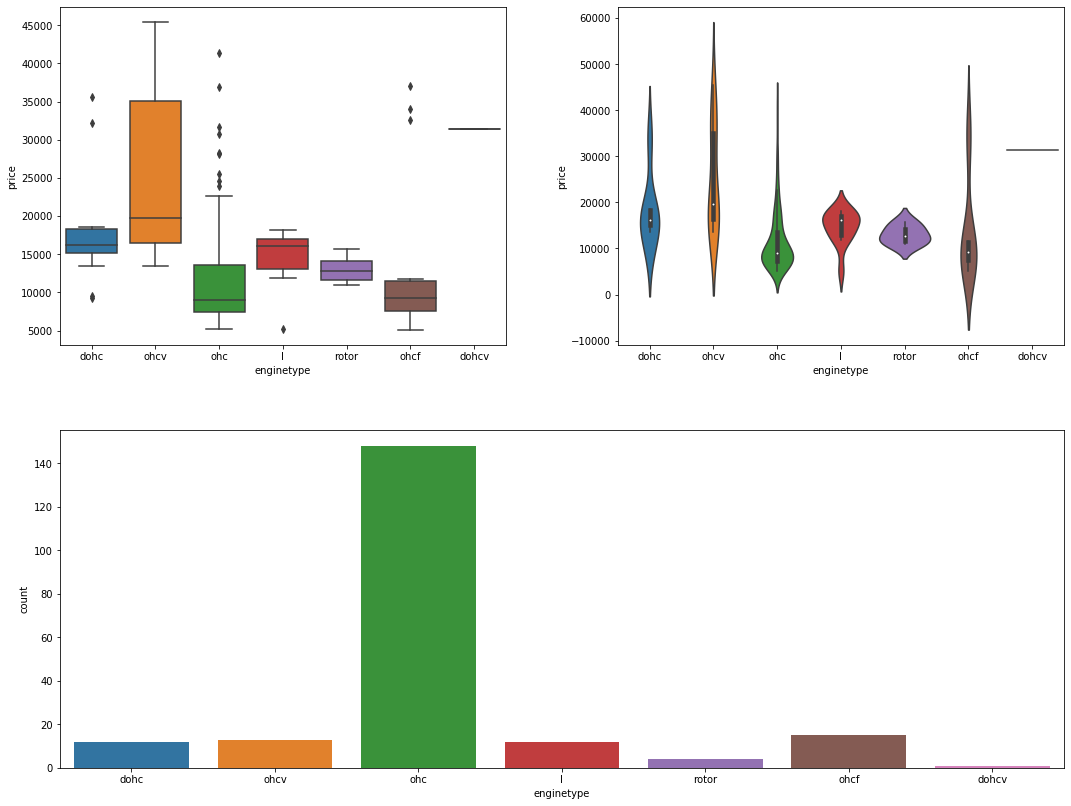

In [118]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='enginetype', y='price',ax=ax0)
sns.violinplot(data = data, x='enginetype', y='price',ax=ax1)
sns.countplot(data=data,x='enginetype',ax=ax2)
plt.show()

In [119]:
def engine_group(x):
    OHC_DOHC=['ohc','dohc','ohcf']
    OHCV_DOHCV=['ohcv','dohcv']
    
    
    if(x in OHC_DOHC):
        return 'OHC_DOHC_ohcf'
    elif(x in OHCV_DOHCV):
        return 'OHCV_DOHCV'
    else:
        return 'I_Rotor'


data['enginetype']=data['enginetype'].apply(lambda x:engine_group(x))

In [120]:
data['enginetype'].value_counts()

OHC_DOHC_ohcf    175
I_Rotor           16
OHCV_DOHCV        14
Name: enginetype, dtype: int64

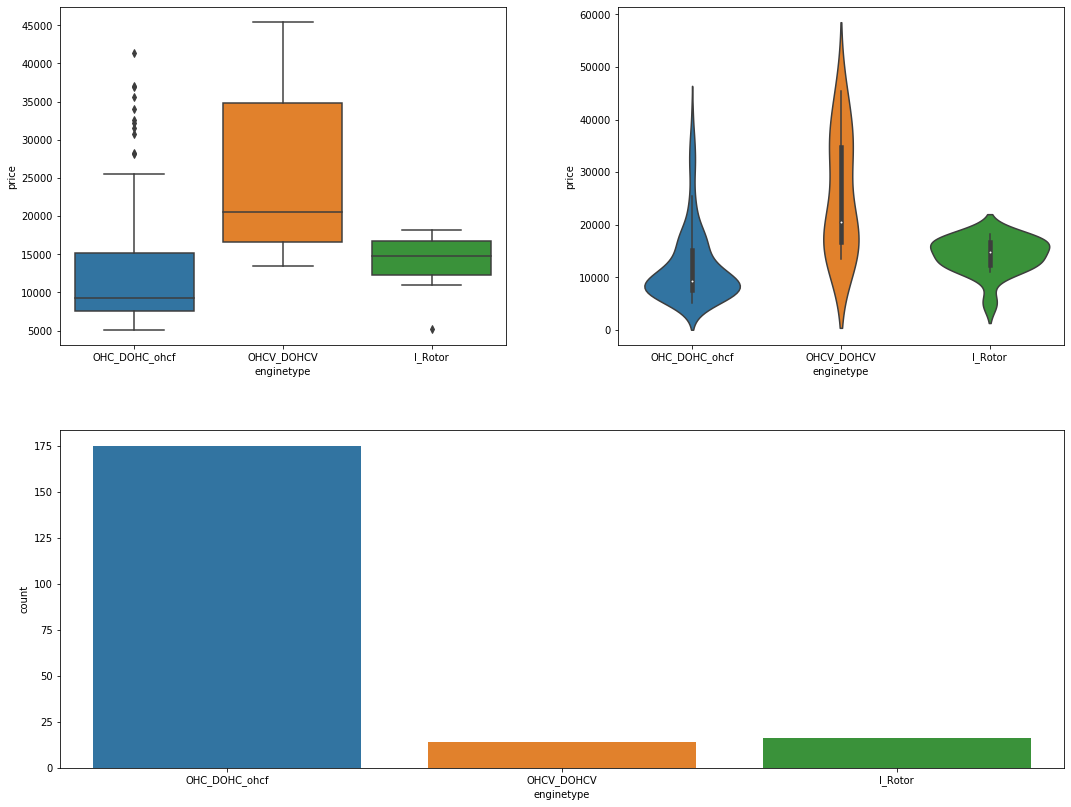

In [122]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='enginetype', y='price',ax=ax0)
sns.violinplot(data = data, x='enginetype', y='price',ax=ax1)
sns.countplot(data=data,x='enginetype',ax=ax2)
plt.show()

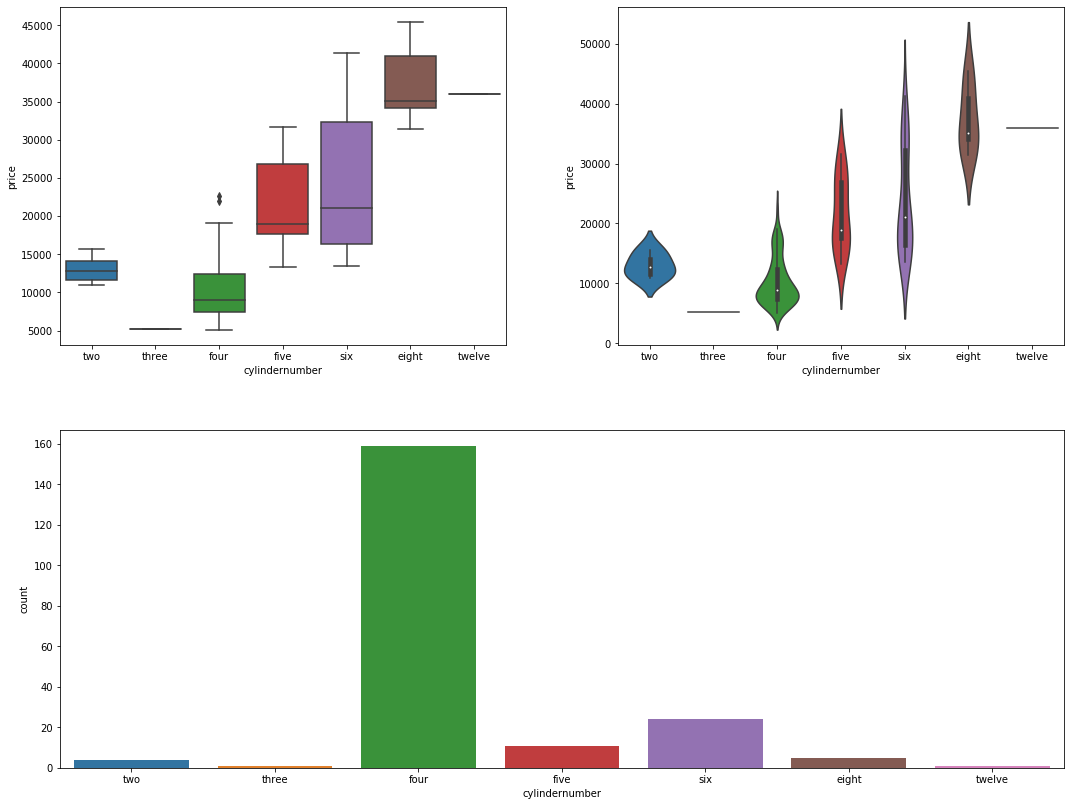

In [123]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='cylindernumber', y='price',ax=ax0,order=['two','three','four','five','six','eight','twelve'])
sns.violinplot(data = data, x='cylindernumber', y='price',ax=ax1,order=['two','three','four','five','six','eight','twelve'])
sns.countplot(data=data,x='cylindernumber',ax=ax2,order=['two','three','four','five','six','eight','twelve'])
plt.show()

#### Grouping is necessary as very few examples in some categories

In [124]:
data['cylindernumber'].value_counts()

four      159
six        24
five       11
eight       5
two         4
twelve      1
three       1
Name: cylindernumber, dtype: int64

In [125]:
def cylinder_group(x):
    two_three_four=['two','three','four']
    five_six=['five','six']
    eight_twelve=['eight','twelve']
    
    
    if(x in two_three_four):
        return 'two_three_four'
    elif(x in five_six):
        return 'five_six'
    elif(x in eight_twelve):
        return 'eight_twelve'
    else:
        return 'others'


data['cylindernumber']=data['cylindernumber'].apply(lambda x:cylinder_group(x))

In [126]:
data['cylindernumber'].value_counts()

two_three_four    164
five_six           35
eight_twelve        6
Name: cylindernumber, dtype: int64

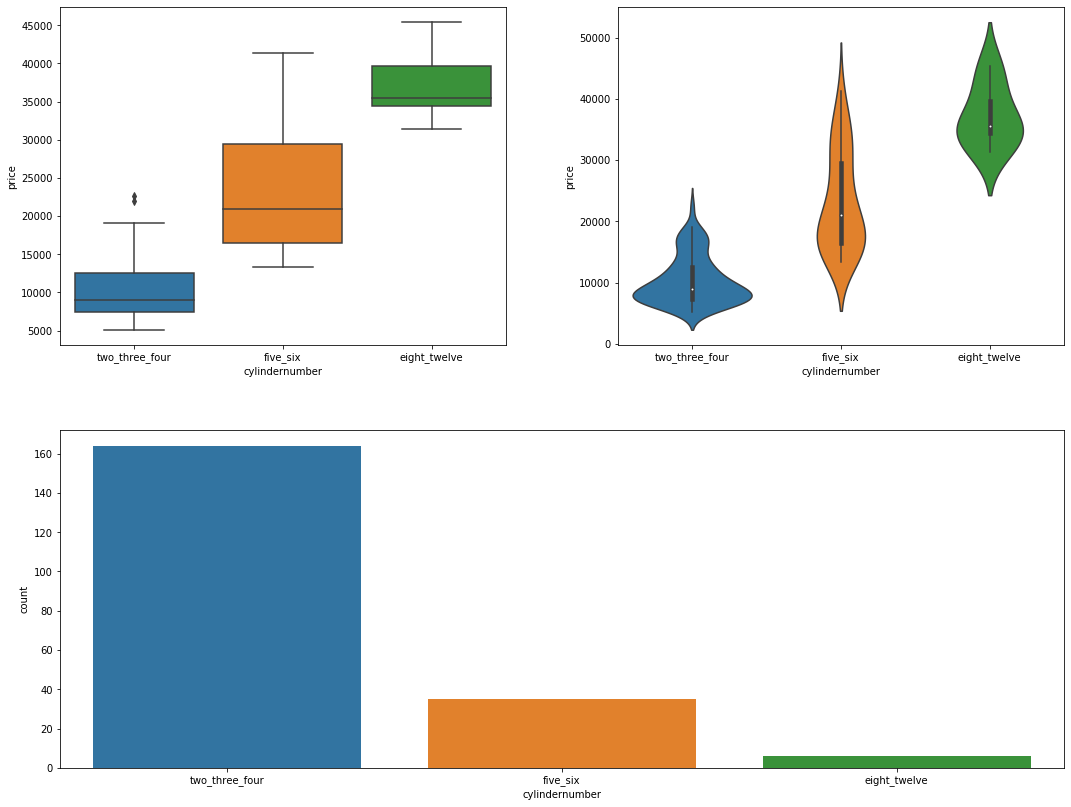

In [127]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='cylindernumber', y='price',ax=ax0,order=['two_three_four','five_six','eight_twelve'])
sns.violinplot(data = data, x='cylindernumber', y='price',ax=ax1,order=['two_three_four','five_six','eight_twelve'])
sns.countplot(data=data,x='cylindernumber',ax=ax2,order=['two_three_four','five_six','eight_twelve'])
plt.show()

majority of cars are under four cylinder. though good variation in price is there. five - six and eight - twelve looks similar

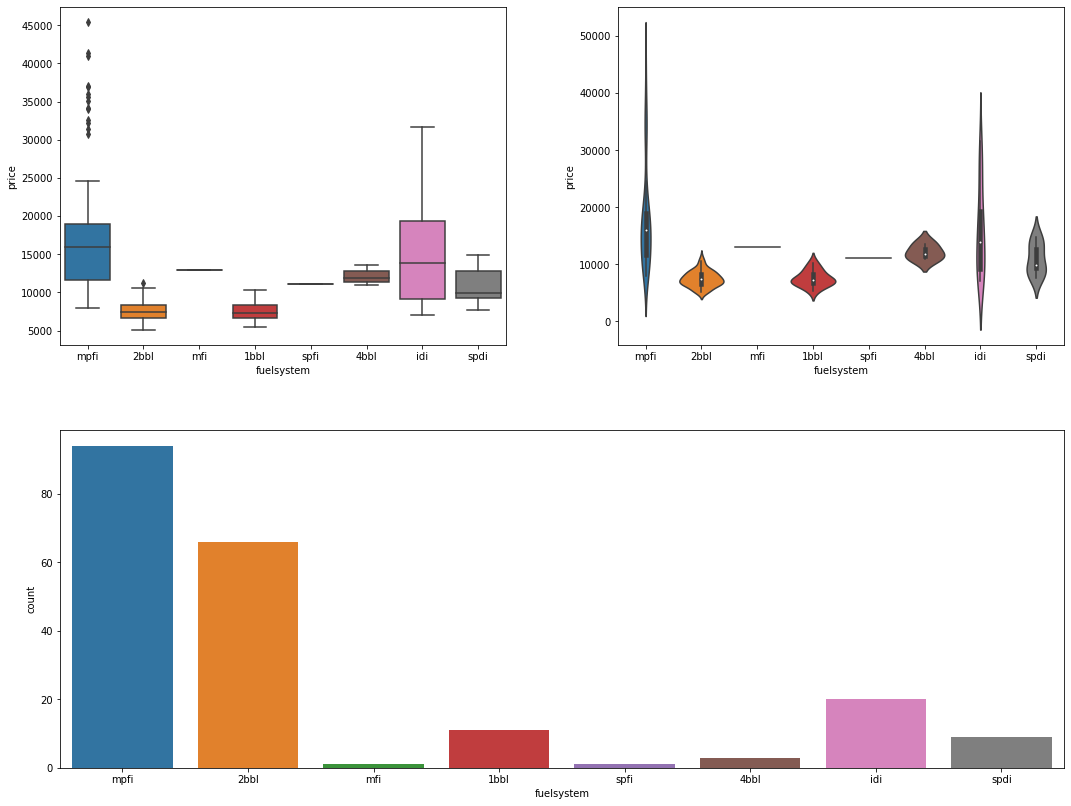

In [128]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='fuelsystem', y='price',ax=ax0,)
sns.violinplot(data = data, x='fuelsystem', y='price',ax=ax1)
sns.countplot(data=data,x='fuelsystem',ax=ax2)
plt.show()

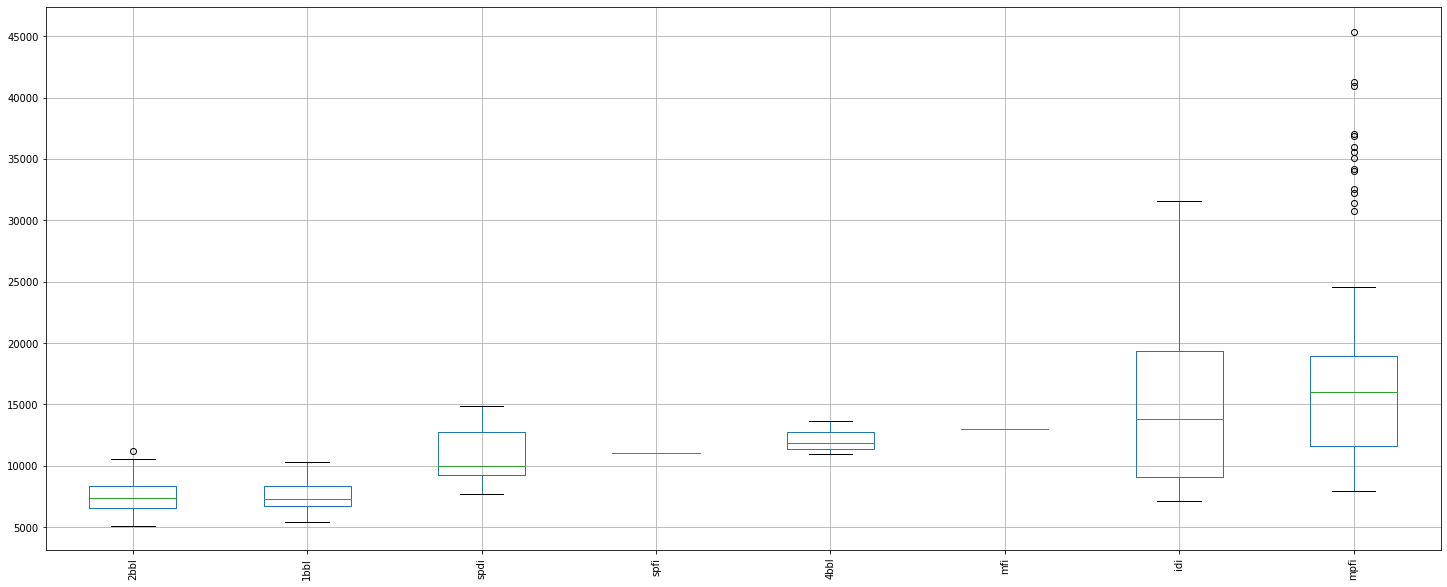

In [129]:
fig = plt.figure(figsize=(25, 10))
boxplot_sorted(data, by=["fuelsystem"], column="price")

## Grouping is neccessary as some categories have very few examples.

In [130]:
datax=data[['fuelsystem','fueltype']]

datax['num1']=1

datax.pivot_table(values='num1',index='fuelsystem', columns='fueltype', aggfunc='sum')

C:\Users\prateekk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


fueltype,diesel,gas
fuelsystem,,
1bbl,NaN,11.0
2bbl,NaN,66.0
4bbl,NaN,3.0
idi,20.0,NaN
mfi,NaN,1.0
mpfi,NaN,94.0
spdi,NaN,9.0
spfi,NaN,1.0


In [131]:
def fuelsystem_group(x):
    bbl1_2=['1bbl','2bbl','four']
    mpfi_s=['mfi','mpfi']
    bbl4_spdi=['4bbl','spdi','spfi']
    
    
    if(x in bbl1_2):
        return 'bbl1_2'
    elif(x in mpfi_s):
        return 'mpfi_s'
    elif(x in bbl4_spdi):
        return 'bbl4_spdi_spfi'
    else:
        return x


data['fuelsystem']=data['fuelsystem'].apply(lambda x:fuelsystem_group(x))

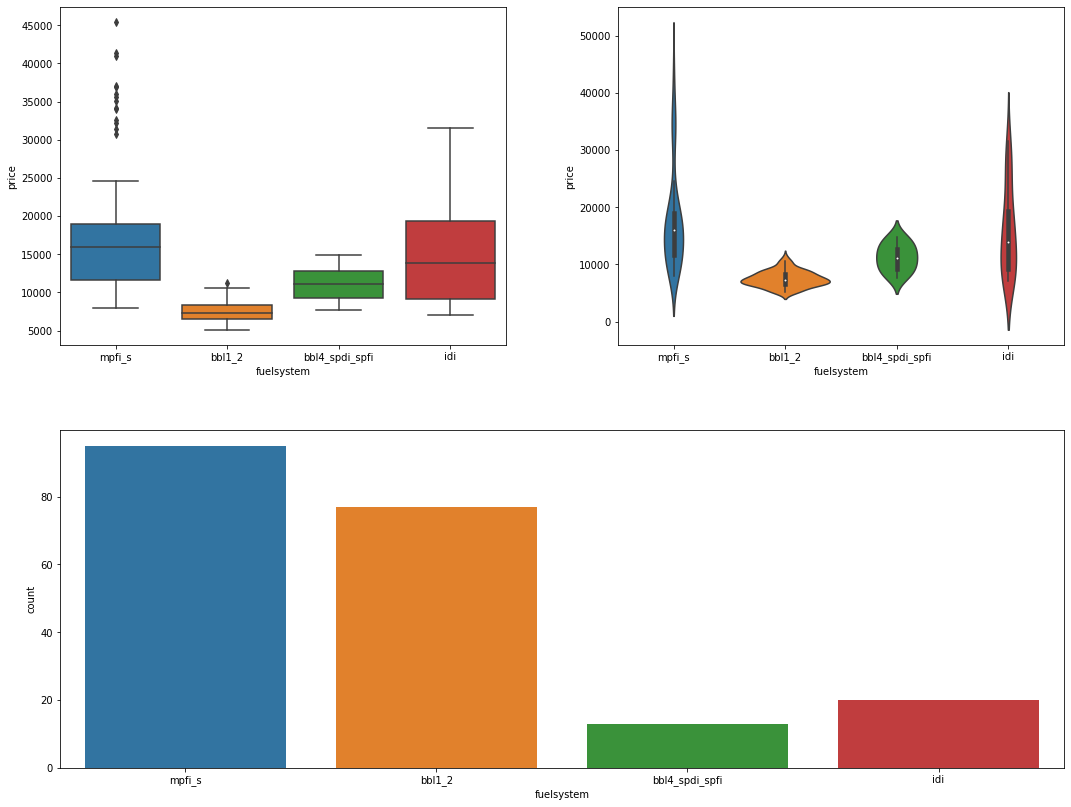

In [132]:
fig = plt.figure(figsize=(18, 14))
gs = grid.GridSpec(2, 2, wspace=0.25, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,:])
sns.boxplot(data = data, x='fuelsystem', y='price',ax=ax0,)
sns.violinplot(data = data, x='fuelsystem', y='price',ax=ax1)
sns.countplot(data=data,x='fuelsystem',ax=ax2)
plt.show()

In [140]:
data_num=data.select_dtypes(include=[np.number])

data_num=data_num.iloc[:,1:15]

data_cat=data.select_dtypes(exclude=[np.number])
data1 = pd.concat([data_cat,data_num],axis=1)

In [141]:
data1.shape

(205, 26)

In [142]:
data1.columns

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem', 'brandName', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'price'],
      dtype='object')

In [143]:
data_final =data1[['symboling','fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem', 'brandName', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'price']]

In [144]:
data_final.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,level_convertible_hardtop,rwd,front,OHC_DOHC_ohcf,two_three_four,mpfi_s,...,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,level_convertible_hardtop,rwd,front,OHC_DOHC_ohcf,two_three_four,mpfi_s,...,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1_2_level_pos,gas,std,two,level_wagon_hatchback,rwd,front,OHCV_DOHCV,five_six,mpfi_s,...,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,1_2_level_pos,gas,std,four,sedan,4wd_fed,front,OHC_DOHC_ohcf,two_three_four,mpfi_s,...,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,1_2_level_pos,gas,std,four,sedan,4wd_fed,front,OHC_DOHC_ohcf,five_six,mpfi_s,...,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [145]:
data_final.to_csv('Data/data_cleaned_2.csv')

In [146]:
from sklearn.model_selection import train_test_split


In [147]:
data_cat.columns

Index(['symboling', 'CarName', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'enginetype',
       'cylindernumber', 'fuelsystem', 'brandName'],
      dtype='object')

In [148]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_final, test_size=0.20)

In [149]:
train.loc[:,'symboling':'brandName'].apply(lambda x:len(x.unique()))

symboling         4
fueltype          2
aspiration        2
doornumber        2
carbody           3
drivewheel        2
enginelocation    2
enginetype        3
cylindernumber    3
fuelsystem        4
brandName         3
dtype: int64

In [150]:
data_final.loc[:,'symboling':'brandName'].apply(lambda x:len(x.unique()))==train.loc[:,'symboling':'brandName'].apply(lambda x:len(x.unique()))

symboling         True
fueltype          True
aspiration        True
doornumber        True
carbody           True
drivewheel        True
enginelocation    True
enginetype        True
cylindernumber    True
fuelsystem        True
brandName         True
dtype: bool

In [151]:
train.to_csv('Data/data_train_2.csv')
test.to_csv('Data/data_test_2.csv')

In [152]:
train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
84,3,gas,turbo,two,level_wagon_hatchback,4wd_fed,front,OHC_DOHC_ohcf,two_three_four,bbl4_spdi_spfi,...,2926,156,3.59,3.86,7.0,145,5000,19,24,14489.0
134,3,gas,std,two,level_wagon_hatchback,4wd_fed,front,OHC_DOHC_ohcf,two_three_four,mpfi_s,...,2707,121,2.54,2.07,9.3,110,5250,21,28,15040.0
109,0,gas,std,four,level_wagon_hatchback,rwd,front,I_Rotor,two_three_four,mpfi_s,...,3230,120,3.46,3.19,8.4,97,5000,19,24,12440.0
184,1_2_level_pos,diesel,std,four,sedan,4wd_fed,front,OHC_DOHC_ohcf,two_three_four,idi,...,2264,97,3.01,3.40,23.0,52,4800,37,46,7995.0
186,1_2_level_pos,gas,std,four,sedan,4wd_fed,front,OHC_DOHC_ohcf,two_three_four,mpfi_s,...,2275,109,3.19,3.40,9.0,85,5250,27,34,8495.0


In [11]:
data['price']=np.log(data['price'])

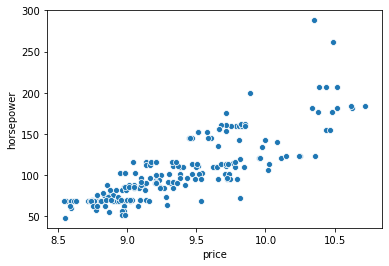

In [15]:
sns.scatterplot(x='price',y='horsepower',data=data)